In [33]:
from fastai.basics import *
from fastai.vision.all import *
from fastai.data.transforms import *

In [6]:
!pip install cv2

ERROR: Could not find a version that satisfies the requirement cv2 (from versions: none)
ERROR: No matching distribution found for cv2


In [1]:
import os
import glob
import cv2
import imageio

import numpy as np 
import pandas as pd 
import nibabel as nib
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from ipywidgets import *
from PIL import Image
from matplotlib.pyplot import figure

from fastai.basics import *
from fastai.vision.all import *
from fastai.data.transforms import *

C:\Users\pc\AppData\Local\Temp\ipykernel_2768\2891234788.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [36]:
import torch

In [37]:
file_list = []
for dirname, _, filenames in os.walk('E:/iacv_data'):
    for filename in filenames:
        file_list.append((dirname, filename)) 

for dirname, _, filenames in os.walk('E:/iacv_volume'):
    for filename in filenames:
        file_list.append((dirname, filename)) 

df_files = pd.DataFrame(file_list, columns =['dirname', 'filename']) 
df_files.sort_values(by=['filename'], ascending=True)  

,dirname,filename
131,E:/iacv_volume,iacv (1).ipynb
132,E:/iacv_volume,iacv (2).ipynb
133,E:/iacv_volume,iacv (3).ipynb
134,E:/iacv_volume,iacv (4).ipynb
135,E:/iacv_volume,iacv.ipynb
...,...,...
234,E:/iacv_volume\volume_pt6,volume-95.nii
235,E:/iacv_volume\volume_pt6,volume-96.nii
236,E:/iacv_volume\volume_pt6,volume-97.nii
237,E:/iacv_volume\volume_pt6,volume-98.nii


In [38]:
# Map CT scan and label 

df_files["mask_dirname"]  = ""
df_files["mask_filename"] = ""

for i in range(131):
    ct = f"volume-{i}.nii"
    mask = f"segmentation-{i}.nii"
    
    df_files.loc[df_files['filename'] == ct, 'mask_filename'] = mask
    df_files.loc[df_files['filename'] == ct, 'mask_dirname'] = "E:/iacv_data"

# drop segment rows
df_files = df_files[df_files.mask_filename != ''].sort_values(by=['filename']).reset_index(drop=True) 

df_files


,dirname,filename,mask_dirname,mask_filename
0,E:/iacv_volume\volume_pt1,volume-0.nii,E:/iacv_data,segmentation-0.nii
1,E:/iacv_volume\volume_pt1,volume-1.nii,E:/iacv_data,segmentation-1.nii
2,E:/iacv_volume\volume_pt1,volume-10.nii,E:/iacv_data,segmentation-10.nii
3,E:/iacv_volume\volume_pt6,volume-100.nii,E:/iacv_data,segmentation-100.nii
4,E:/iacv_volume\volume_pt8,volume-101.nii,E:/iacv_data,segmentation-101.nii
...,...,...,...,...
126,E:/iacv_volume\volume_pt6,volume-95.nii,E:/iacv_data,segmentation-95.nii
127,E:/iacv_volume\volume_pt6,volume-96.nii,E:/iacv_data,segmentation-96.nii
128,E:/iacv_volume\volume_pt6,volume-97.nii,E:/iacv_data,segmentation-97.nii
129,E:/iacv_volume\volume_pt6,volume-98.nii,E:/iacv_data,segmentation-98.nii


In [39]:
def read_nii(filepath):
    '''
    Reads .nii file and returns pixel array
    '''
    ct_scan = nib.load(filepath)
    array   = ct_scan.get_fdata()
    array   = np.rot90(np.array(array))
    return(array)

In [40]:
# Read sample

sample = 0
sample_ct = read_nii(df_files.loc[sample,'dirname']+"/"+df_files.loc[sample,'filename'])
sample_mask = read_nii(df_files.loc[sample,'mask_dirname']+"/"+df_files.loc[sample,'mask_filename'])

print(f'CT Shape:   {sample_ct.shape}\nMask Shape: {sample_mask.shape}')


CT Shape:   (512, 512, 75)
Mask Shape: (512, 512, 75)


In [41]:
print(np.amin(sample_ct), np.amax(sample_ct))
print(np.amin(sample_mask), np.amax(sample_mask))

-3024.0 1410.0
0.0 2.0


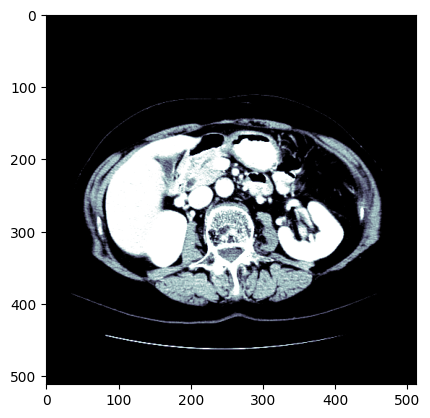

In [42]:
# Preprocess the nii file 
# Source https://docs.fast.ai/medical.imaging

dicom_windows = types.SimpleNamespace(
    brain=(80,40),
    subdural=(254,100),
    stroke=(8,32),
    brain_bone=(2800,600),
    brain_soft=(375,40),
    lungs=(1500,-600),
    mediastinum=(350,50),
    abdomen_soft=(400,50),
    liver=(150,30),
    spine_soft=(250,50),
    spine_bone=(1800,400),
    custom = (200,60)
)

@patch
def windowed(self:Tensor, w, l):
    px = self.clone()
    px_min = l - w//2
    px_max = l + w//2
    px[px<px_min] = px_min
    px[px>px_max] = px_max
    return (px-px_min) / (px_max-px_min)

plt.imshow(tensor(sample_ct[...,50].astype(np.float32)).windowed(*dicom_windows.liver), cmap=plt.cm.bone);


In [43]:
def plot_sample(array_list, color_map = 'nipy_spectral'):
    '''
    Plots and a slice with all available annotations
    '''
    fig = plt.figure(figsize=(20,16), dpi=100)

    plt.subplot(1,4,1)
    plt.imshow(array_list[0], cmap='bone')
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1,4,2)
    plt.imshow(tensor(array_list[0].astype(np.float32)).windowed(*dicom_windows.liver), cmap='bone');
    plt.title('Windowed Image')
    plt.axis('off')
             
    plt.subplot(1,4,3)
    plt.imshow(array_list[1], alpha=0.5, cmap=color_map)
    plt.title('Mask')
    plt.axis('off')
    plt.subplot(1,4,4)
    plt.imshow(array_list[0], cmap='bone')
    plt.imshow(array_list[1], alpha=0.5, cmap=color_map)
    plt.title('Liver & Mask')
    plt.axis('off')
    
    plt.show()

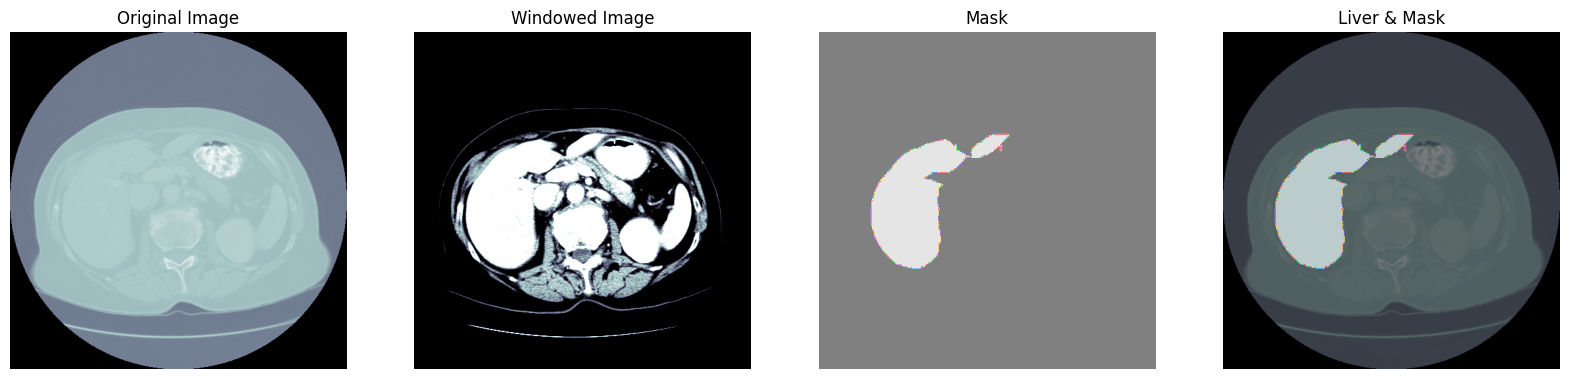

In [44]:
sample = 55

sample_slice = tensor(sample_ct[...,sample].astype(np.float32))

plot_sample([sample_ct[..., sample],
             sample_mask[..., sample]])

In [45]:
# Check the mask values
mask = Image.fromarray(sample_mask[...,sample].astype('uint8'), mode="L")
unique, counts = np.unique(mask, return_counts=True)
print(np.array((unique, counts)).T)


[[     0 244111]
 [     1  18033]]


<Axes: >

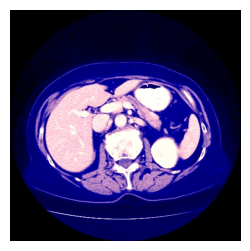

In [46]:
# Preprocessing functions
# Source https://docs.fast.ai/medical.imaging

class TensorCTScan(TensorImageBW): _show_args = {'cmap':'bone'}

@patch
def freqhist_bins(self:Tensor, n_bins=100):
    "A function to split the range of pixel values into groups, such that each group has around the same number of pixels"
    imsd = self.view(-1).sort()[0]
    t = torch.cat([tensor([0.001]),
                   torch.arange(n_bins).float()/n_bins+(1/2/n_bins),
                   tensor([0.999])])
    t = (len(imsd)*t).long()
    return imsd[t].unique()
    
@patch
def hist_scaled(self:Tensor, brks=None):
    "Scales a tensor using `freqhist_bins` to values between 0 and 1"
    if self.device.type=='cuda': return self.hist_scaled_pt(brks)
    if brks is None: brks = self.freqhist_bins()
    ys = np.linspace(0., 1., len(brks))
    x = self.numpy().flatten()
    x = np.interp(x, brks.numpy(), ys)
    return tensor(x).reshape(self.shape).clamp(0.,1.)
    
    
@patch
def to_nchan(x:Tensor, wins, bins=None):
    res = [x.windowed(*win) for win in wins]
    if not isinstance(bins,int) or bins!=0: res.append(x.hist_scaled(bins).clamp(0,1))
    dim = [0,1][x.dim()==3]
    return TensorCTScan(torch.stack(res, dim=dim))

@patch
def save_jpg(x:(Tensor), path, wins, bins=None, quality=120):
    fn = Path(path).with_suffix('.jpg')
    x = (x.to_nchan(wins, bins)*255).byte()
    im = Image.fromarray(x.permute(1,2,0).numpy(), mode=['RGB','CMYK'][x.shape[0]==4])
    im.save(fn, quality=quality)
_,axs = subplots(1,1)

sample_slice.save_jpg('test.jpg', [dicom_windows.liver, dicom_windows.custom])
show_image(Image.open('test.jpg'), ax=axs[0], figsize=(8, 6))

In [19]:
# Make custom JPG files for Unet training
# Total number of 131 nii files contains 67072 slices 

GENERATE_JPG_FILES = True

if (GENERATE_JPG_FILES) :
    
    path = Path(".")

    os.makedirs('train_images',exist_ok=True)
    os.makedirs('train_masks',exist_ok=True)

    for ii in tqdm(range(0,len(df_files),3)): # take 1/3 nii files for training
        curr_ct        = read_nii(df_files.loc[ii,'dirname']+"/"+df_files.loc[ii,'filename'])
        curr_mask      = read_nii(df_files.loc[ii,'mask_dirname']+"/"+df_files.loc[ii,'mask_filename'])
        curr_file_name = str(df_files.loc[ii,'filename']).split('.')[0]
        curr_dim       = curr_ct.shape[2] # 512, 512, curr_dim

        for curr_slice in range(0,curr_dim,2): # export every 2nd slice for training
            data = tensor(curr_ct[...,curr_slice].astype(np.float32))
            mask = Image.fromarray(curr_mask[...,curr_slice].astype('uint8'), mode="L")
            data.save_jpg(f"train_images/{curr_file_name}_slice_{curr_slice}.jpg", [dicom_windows.liver,dicom_windows.custom])
            mask.save(f"train_masks/{curr_file_name}_slice_{curr_slice}_mask.png")
else:
    
    path = Path("E:/iacv_train")
 # read jpg from saved kernel output

  0%|          | 0/44 [00:00<?, ?it/s]

AttributeError: 'Tensor' object has no attribute 'save_jpg'

In [47]:
path = Path(".")

In [13]:
bs = 16
im_size = 128

codes = np.array(["background","liver","tumor"])
    
def get_x(fname:Path): return fname
def label_func(x): return path/'train_masks'/f'{x.stem}_mask.png'

tfms = [IntToFloatTensor(),Normalize()]

db = DataBlock(blocks=(ImageBlock(),MaskBlock(codes)),  #codes = {"Backround": 0,"Liver": 1,"Tumor": 2}
               batch_tfms=tfms,
               splitter=RandomSplitter(),
               item_tfms=[Resize(im_size)],
               get_items=get_image_files,
               get_y=label_func
              )

ds = db.datasets(source=path/'train_images')

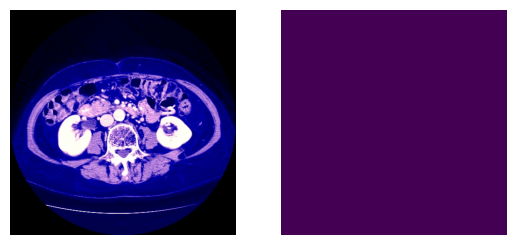

In [14]:
idx=20
imgs = [ds[idx][0],ds[idx][1]]
fig,axs = plt.subplots(1, 2)
for i,ax in enumerate(axs.flatten()):
    ax.axis('off')
    ax.imshow(imgs[i]) #, cmap='gray'

In [15]:
unique, counts = np.unique(array(ds[idx][1]), return_counts=True)

print( np.array((unique, counts)).T)

[[     0 262144]]


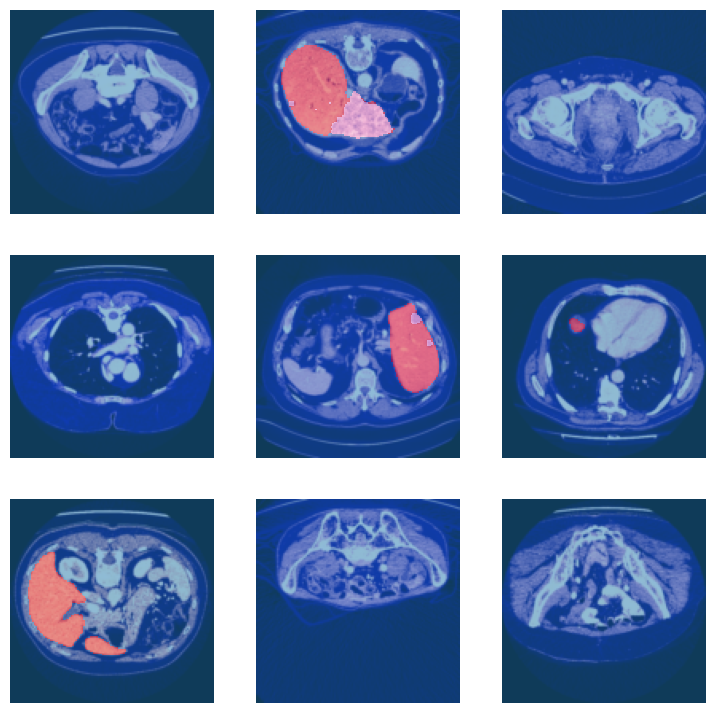

In [16]:
dls = db.dataloaders(path/'train_images',bs = bs) #, num_workers=0
dls.show_batch()

In [17]:
def foreground_acc(inp, targ, bkg_idx=0, axis=1):  # exclude a background from metric
    "Computes non-background accuracy for multiclass segmentation"
    targ = targ.squeeze(1)
    mask = targ != bkg_idx
    return (inp.argmax(dim=axis)[mask]==targ[mask]).float().mean() 

def cust_foreground_acc(inp, targ):  # # include a background into the metric
    return foreground_acc(inp=inp, targ=targ, bkg_idx=3, axis=1) # 3 is a dummy value to include the background which is 0

In [ ]:
from manet import manet

In [27]:
learn = unet_learner(dls, resnet34 ,loss_func=CrossEntropyLossFlat(axis=1), metrics=[foreground_acc, cust_foreground_acc]) 

In [23]:
learn.fine_tune(5, wd=0.1, cbs=SaveModelCallback() )

epoch,train_loss,valid_loss,foreground_acc,cust_foreground_acc,time
0,0.012920,0.009750,0.883687,0.996573,52:18


Better model found at epoch 0 with valid_loss value: 0.009749909862875938.


epoch,train_loss,valid_loss,foreground_acc,cust_foreground_acc,time
0,0.007550,0.005333,0.946240,0.998066,55:32
1,0.005528,0.004619,0.939403,0.998307,55:58
2,0.003887,0.003630,0.966410,0.998599,55:04
3,0.003044,0.002967,0.964453,0.998831,55:08
4,0.002717,0.002802,0.968655,0.998874,55:08


Better model found at epoch 0 with valid_loss value: 0.005333402659744024.
Better model found at epoch 1 with valid_loss value: 0.004619174171239138.
Better model found at epoch 2 with valid_loss value: 0.003629978746175766.
Better model found at epoch 3 with valid_loss value: 0.0029666542541235685.
Better model found at epoch 4 with valid_loss value: 0.0028016907162964344.


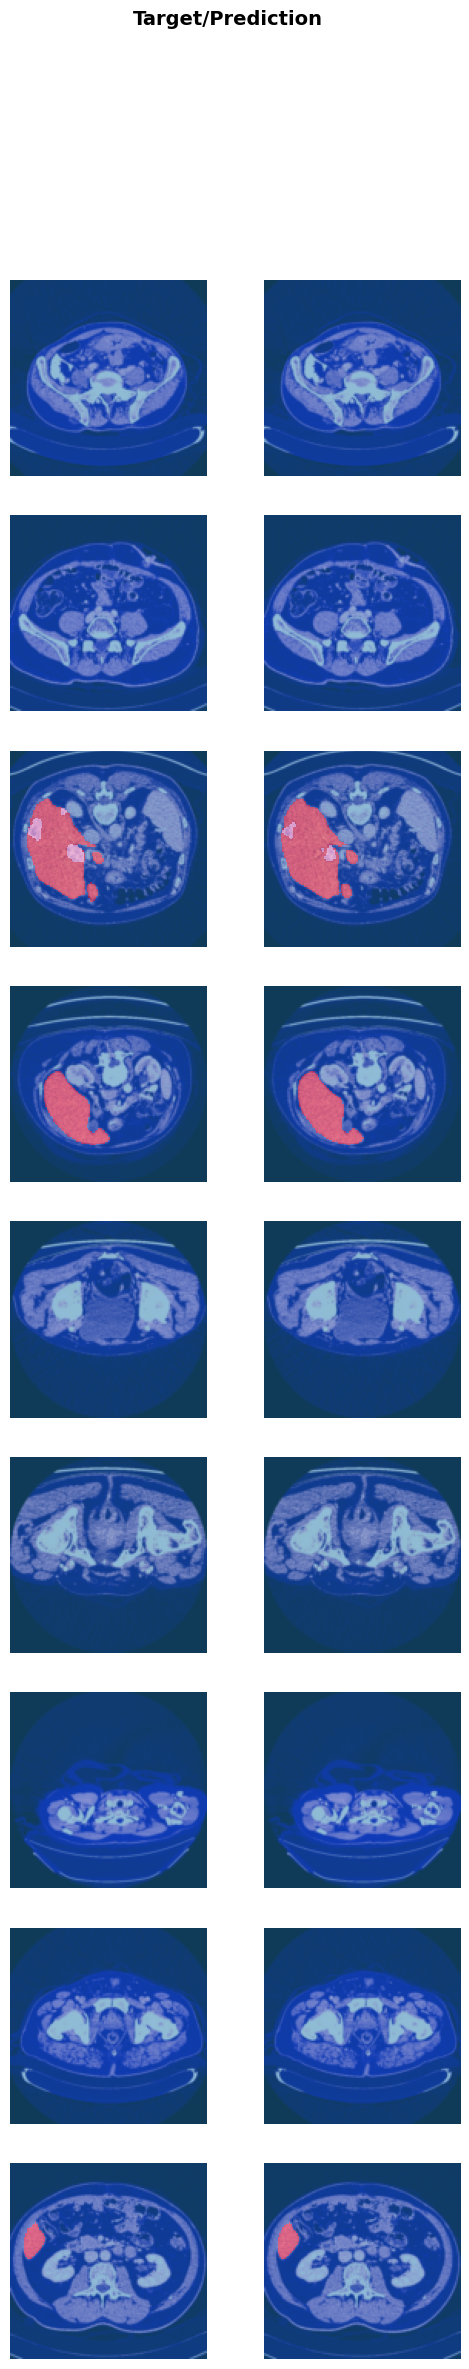

In [24]:
learn.show_results()

In [25]:
learn.export(path/f'Liver_segmentation')

NameError: name 'learn' is not defined

In [48]:
# Load saved model

if (GENERATE_JPG_FILES) :
    
    tfms = [Resize(im_size), IntToFloatTensor(),Normalize()]
    learn0               = load_learner(path/f'Liver_segmentation',cpu=False )
    learn0.dls.transform = tfms

In [49]:
def nii_tfm(fn,wins): 

    test_nii  = read_nii(fn)
    curr_dim  = test_nii.shape[2] # 512, 512, curr_dim
    slices = []
    
    for curr_slice in range(curr_dim):
        data = tensor(test_nii[...,curr_slice].astype(np.float32))
        data = (data.to_nchan(wins)*255).byte()
        slices.append(TensorImage(data))
                      
    return slices 

(512, 512, 908)


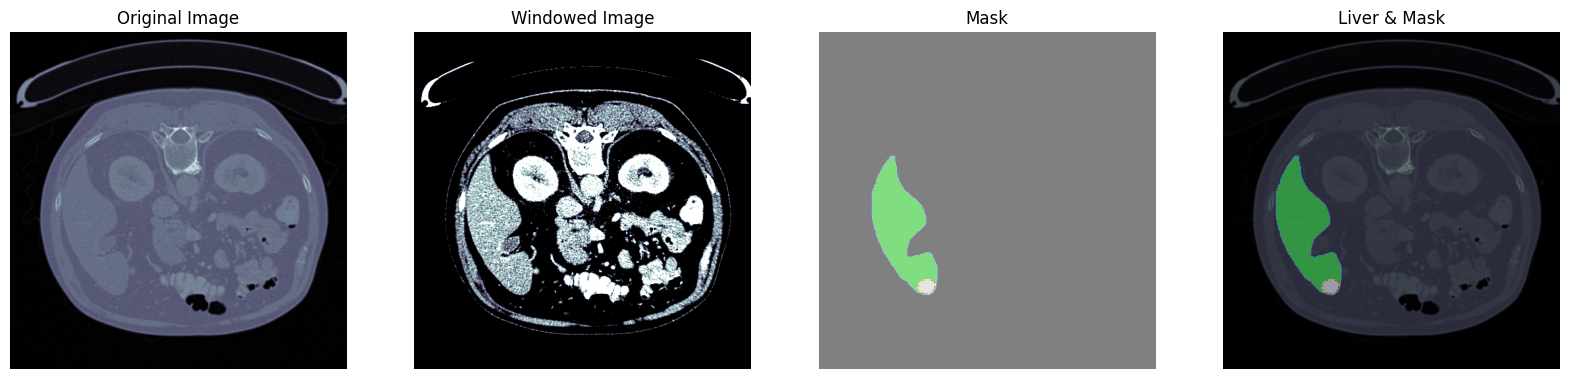

In [50]:
tst = 20

test_nii   = read_nii(df_files.loc[tst,'dirname']+"/"+df_files.loc[tst,'filename'])
test_mask  = read_nii(df_files.loc[tst,'mask_dirname']+"/"+df_files.loc[tst,'mask_filename'])
print(test_nii.shape)

test_slice_idx = 500

sample_slice = tensor(test_nii[...,test_slice_idx].astype(np.float32))

plot_sample([test_nii[...,test_slice_idx], test_mask[...,test_slice_idx]])

In [51]:
# Prepare a nii test file for prediction 

test_files = nii_tfm(df_files.loc[tst,'dirname']+"/"+df_files.loc[tst,'filename'],[dicom_windows.liver, dicom_windows.custom])
print("Number of test slices: ",len(test_files))

Number of test slices:  908


<Axes: >

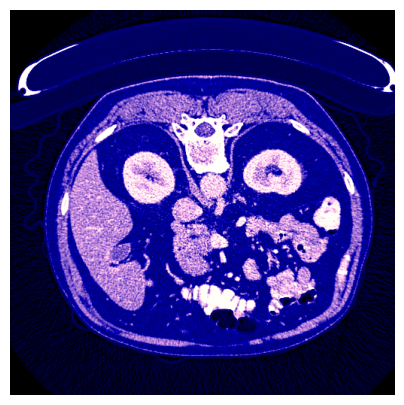

In [52]:
show_image(test_files[test_slice_idx])

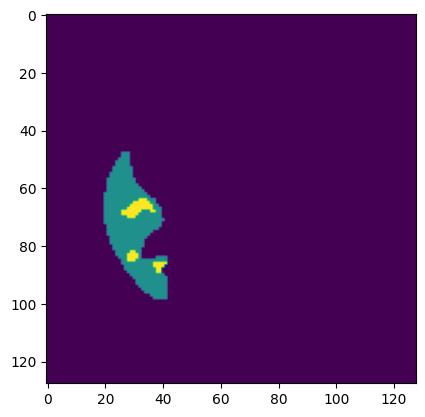

In [53]:
# Get predictions for a Test file

test_dl = learn0.dls.test_dl(test_files)
preds, y = learn0.get_preds(dl=test_dl)

predicted_mask = np.argmax(preds, axis=1)
plt.imshow(predicted_mask[test_slice_idx])


In [87]:
import gradio as gr
import os
import numpy as np
import nibabel as nib
from fastai.vision.all import *
from fastai.medical.imaging import *

# Define the path to the model directory
model_path = Path("C:/Users/pc/Liver_segmentation")

# Load saved model
GENERATE_JPG_FILES = True  # Assuming this is defined somewhere

if GENERATE_JPG_FILES:
    tfms = [Resize(im_size), IntToFloatTensor(), Normalize()]
    learn0 = load_learner(model_path, cpu=False)
    learn0.dls.transform = tfms

# Define preprocessing functions
def read_nii(filepath):
    ct_scan = nib.load(filepath)
    array = ct_scan.get_fdata()
    array = np.rot90(np.array(array))
    return array

def preprocess_nii(file_path, windows):
    ct_data = read_nii(file_path)
    tensor_ct_data = tensor(ct_data).unsqueeze(0)  # Add batch dimension
    preprocessed_data = tensor_ct_data.to_nchan(windows).squeeze(0)  # Remove batch dimension
    return preprocessed_data

def predict_mask(segmentation_file, volume_file):
    # Preprocess the volume file
    preprocessed_volume = preprocess_nii(volume_file.name, [dicom_windows.liver, dicom_windows.custom])

    # Assuming the segmentation model requires the preprocessed volume data as input
    test_dl = learn0.dls.test_dl(preprocessed_volume)
    preds, _ = learn0.get_preds(dl=test_dl)
    predicted_mask = np.argmax(preds, axis=1)
    return predicted_mask

# Gradio Interface
iface = gr.Interface(
    fn=predict_mask,
    inputs=[
        gr.inputs.File(label="Segmentation File"),
        gr.inputs.File(label="Volume File")
    ],
    outputs="image",
    title="Liver Segmentation",
    description="Upload a segmentation.nii file and a volume.nii file for liver segmentation."
)

iface.launch()



AttributeError: module 'gradio' has no attribute 'inputs'

In [92]:
import gradio as gr
import os
import numpy as np
import nibabel as nib
from fastai.vision.all import *
from fastai.medical.imaging import *

# Define the path to the model directory
model_path = Path("C:/Users/pc/Liver_segmentation")

# Load saved model (assuming you have a function for this)
GENERATE_JPG_FILES = True  # Assuming this is defined somewhere
learn0 = load_learner(model_path, cpu=False)  # Replace with your model loading logic

# Define preprocessing functions
def read_nii(filepath):
    ct_scan = nib.load(filepath)
    array = ct_scan.get_fdata()
    array = np.rot90(np.array(array))
    return array



def predict_mask(segmentation_img, volume_img):
    # Convert uploaded images to numpy arrays
    segmentation_np = segmentation_img.astype(np.float32)
    volume_np = volume_img.astype(np.float32)

    # Preprocess the volume file
    preprocessed_volume = tensor(volume_np).permute(2, 0, 1)  # Reshape and permute dimensions
    preprocessed_volume = preprocessed_volume.unsqueeze(0)  # Add batch dimension

    # Assuming the segmentation model requires the preprocessed volume data as input
    test_dl = learn0.dls.test_dl(preprocessed_volume)
    preds, _ = learn0.get_preds(dl=test_dl)
    predicted_mask = np.argmax(preds, axis=1)
    return predicted_mask

# Gradio Interface (using the updated syntax for inputs)
iface = gr.Interface(
    fn=predict_mask,
    inputs=[
        gr.Image(label="Segmentation Image", type="numpy"),
        gr.Image(label="Volume Image", type="numpy")
    ],
    outputs="image",
    title="Liver Segmentation",
    description="Upload a segmentation image and a volume image for liver segmentation."
)

iface.launch()


Running on local URL:  http://127.0.0.1:7866

To create a public link, set `share=True` in `launch()`.


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "C:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\uvicorn\protocols\http\h11_impl.py", line 407, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\uvicorn\middleware\proxy_headers.py", line 69, in __call__
    return await self.app(scope, receive, send)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\fastapi\applications.py", line 1054, in __call__
    await super().__call__(scope, receive, send)
  File "C:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\starlette\applications.py", line 123, in __call__
    await self.middleware_stack(scope, receive, send)
  File "C:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\site-packages

In [ ]:
import gradio as gr
import os
import numpy as np
import nibabel as nib
from fastai.vision.all import *
from fastai.medical.imaging import *

# Load saved model
if GENERATE_JPG_FILES:
    tfms = [Resize(im_size), IntToFloatTensor(), Normalize()]
    learn0 = load_learner(path / 'Liver_segmentation', cpu=False)
    learn0.dls.transform = tfms

def read_nii(filepath):
    ct_scan = nib.load(filepath)
    array = ct_scan.get_fdata()
    array = np.rot90(np.array(array))
    return array

def nii_tfm(fn, wins):
    test_nii = read_nii(fn)
    curr_dim = test_nii.shape[2]
    slices = []
    for curr_slice in range(curr_dim):
        data = tensor(test_nii[..., curr_slice].astype(np.float32))
        data = (data.to_nchan(wins) * 255).byte()
        slices.append(TensorImage(data))
    return slices

def predict_mask(volume_file):
    # Assuming the segmentation model requires the volume data as input
    volume_data = read_nii(volume_file.name)
    test_files = nii_tfm(volume_file.name, [dicom_windows.liver, dicom_windows.custom])
    test_dl = learn0.dls.test_dl(test_files)
    preds, _ = learn0.get_preds(dl=test_dl)
    predicted_mask = np.argmax(preds, axis=1)
    return predicted_mask

iface = gr.Interface(
    fn=predict_mask,
    inputs=["file"],
    outputs="image",
    title="Liver Segmentation",
    description="Upload a volume.nii file for liver segmentation."
)

iface.launch()

In [38]:
pip install pydicom



   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
    --------------------------------------- 0.0/1.8 MB 640.0 kB/s eta 0:00:03
   - -------------------------------------- 0.1/1.8 MB 435.7 kB/s eta 0:00:04
   - -------------------------------------- 0.1/1.8 MB 491.5 kB/s eta 0:00:04
   - -------------------------------------- 0.1/1.8 MB 456.6 kB/s eta 0:00:04
   -- ------------------------------------- 0.1/1.8 MB 514.3 kB/s eta 0:00:04
   --- ------------------------------------ 0.1/1.8 MB 491.5 kB/s eta 0:00:04
   --- ------------------------------------ 0.2/1.8 MB 490.7 kB/s eta 0:00:04
   ---- ----------------------------------- 0.2/1.8 MB 540.4 kB/s eta 0:00:03
   ---- ----------------------------------- 0.2/1.8 MB 523.8 kB/s eta 0:00:03
   ----- ---------------------------------- 0.2/1.8 MB 502.2 kB/s eta 0:00:04
   ------ --

In [45]:
import gradio as gr

# Assuming you have functions for loading the model, processing data, and making predictions

def load_model(model_path):
    # Implement your model loading logic here
    # (e.g., using libraries like fastai or pytorch)
    if (GENERATE_JPG_FILES) :
    
        tfms = [Resize(im_size), IntToFloatTensor(),Normalize()]
        learn0               = load_learner(path/f'Liver_segmentation',cpu=False )
        learn0.dls.transform = tfms
    pass

def nii_tfm(fn,wins): 

    test_nii  = read_nii(fn)
    curr_dim  = test_nii.shape[2] # 512, 512, curr_dim
    slices = []
    
    for curr_slice in range(curr_dim):
        data = tensor(test_nii[...,curr_slice].astype(np.float32))
        data = (data.to_nchan(wins)*255).byte()
        slices.append(TensorImage(data))
                      
    return slices 

def predict(nii_path, model, window_settings):
    # Load data using `nii_tfm`
    test_files = nii_tfm(nii_path, window_settings)

    # Prepare data loader (assuming `learn0.dls.test_dl` is unavailable)
    test_dl = DataLoaders.from_folder(test_files, batch_size=1, shuffle=False)

    # Get predictions (assuming `learn0.get_preds` is unavailable)
    preds, y = model.predict(test_dl)

    # Process predictions (assuming `np.argmax` is the logic)
    predicted_mask = np.argmax(preds, axis=1)

    return predicted_mask

def gradio_interface():
    # Load the model (replace with your actual loading logic)
    model = load_model('path/to/your/model')

    # Define input and output components
    inputs = gr.File(label='Upload NIfTI File (.nii)')
    window_settings = gr.Slider(label='Window Settings', minimum=0, maximum=255, step=1, value=[dicom_windows.liver, dicom_windows.custom])
    outputs = gr.Image(label='Predicted Mask')

    # Define the prediction function using the loaded model
    def predict_with_model(nii_file, window_settings):
        predicted_mask = predict(nii_file, model, window_settings)
        return predicted_mask

    # Create the Gradio interface
    interface = gr.Interface(
        fn=predict_with_model,
        inputs=inputs,
        outputs=outputs,
        title='Liver Segmentation Prediction',
        description='Upload a NIfTI file and adjust window settings to get the predicted liver segmentation mask.'
    )

    # Launch the interface
    interface.launch()




In [39]:
import gradio as gr
import os
import numpy as np
import nibabel as nib
from fastai.vision.all import *
from fastai.medical.imaging import *

# Function to read .nii file and return pixel array
def read_nii(filepath):
    ct_scan = nib.load(filepath)
    array = ct_scan.get_fdata()
    array = np.rot90(np.array(array))
    return array

# Define the function to predict the mask
def predict_mask(test_nii_path, test_mask_path, test_slice_idx, learn_model_path):
    # Load the trained model
    learn = load_learner(learn_model_path)
    
    # Read the test NII and mask files
    test_nii = read_nii(test_nii_path)
    test_mask = read_nii(test_mask_path)
    
    # Select the slice
    sample_slice = tensor(test_nii[..., test_slice_idx].astype(np.float32))
    
    # Preprocess the slice
    sample_slice = (sample_slice.windowed(*dicom_windows.liver)*255).byte()
    
    # Get predictions
    preds, _ = learn.get_preds(dl=learn.dls.test_dl([sample_slice]))
    predicted_mask = np.argmax(preds, axis=1)
    
    return predicted_mask

# Create Gradio interface
iface = gr.Interface(
    fn=predict_mask,
    inputs=[
        gr.inputs.Textbox(label="Test NII Path"),
        gr.inputs.Textbox(label="Test Mask Path"),
        gr.inputs.Slider(minimum=0, maximum=999, step=1, default=500, label="Test Slice Index"),
        gr.inputs.Textbox(label="Learn Model Path")
    ],
    outputs=gr.outputs.Image(label="Predicted Mask")
)

# Launch the interface
iface.launch()

AttributeError: module 'gradio' has no attribute 'inputs'

In [42]:
pip install -U gradio


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spacy 3.7.4 requires typer<0.10.0,>=0.3.0, but you have typer 0.12.3 which is incompatible.
weasel 0.3.4 requires typer<0.10.0,>=0.3.0, but you have typer 0.12.3 which is incompatible.



   ---------------------------------------- 0.0/17.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/17.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/17.1 MB 435.7 kB/s eta 0:00:40
   ---------------------------------------- 0.1/17.1 MB 469.7 kB/s eta 0:00:37
   ---------------------------------------- 0.1/17.1 MB 512.0 kB/s eta 0:00:34
   ---------------------------------------- 0.1/17.1 MB 492.8 kB/s eta 0:00:35
   ---------------------------------------- 0.1/17.1 MB 481.4 kB/s eta 0:00:36
   ---------------------------------------- 0.1/17.1 MB 502.3 kB/s eta 0:00:34
   ---------------------------------------- 0.2/17.1 MB 499.5 kB/s eta 0:00:34
   ---------------------------------------- 0.2/17.1 MB 484.9 kB/s eta 0:00:35
   ---------------------------------------- 0.2/17.1 MB 498.9 kB/s eta 0:00:34
    --------------------------------------- 0.2/17.1 MB 497.3 kB/s eta 0:00:35
    --------------------------------------- 0.3/17.1 MB 497.1 kB/s et

In [48]:
import gradio as gr
import os
import numpy as np
import nibabel as nib
from fastai.vision.all import *
from fastai.medical.imaging import *

# Load saved model
if GENERATE_JPG_FILES:
    tfms = [Resize(im_size), IntToFloatTensor(), Normalize()]
    learn0 = load_learner(path / 'Liver_segmentation', cpu=False)
    learn0.dls.transform = tfms

def read_nii(filepath):
    ct_scan = nib.load(filepath)
    array = ct_scan.get_fdata()
    array = np.rot90(np.array(array))
    return array

def nii_tfm(fn, wins):
    test_nii = read_nii(fn)
    curr_dim = test_nii.shape[2]
    slices = []
    for curr_slice in range(curr_dim):
        data = tensor(test_nii[..., curr_slice].astype(np.float32))
        data = (data.to_nchan(wins) * 255).byte()
        slices.append(TensorImage(data))
    return slices

def predict_mask(test_files):
    test_dl = learn0.dls.test_dl(test_files)
    preds, _ = learn0.get_preds(dl=test_dl)
    predicted_mask = np.argmax(preds, axis=1)
    return predicted_mask

iface = gr.Interface(
    fn=predict_mask,
    inputs=["file"],
    outputs="image",
    title="Liver Segmentation",
    description="Upload a NIfTI file for liver segmentation."
)

iface.launch()


Running on local URL:  http://127.0.0.1:7862

To create a public link, set `share=True` in `launch()`.


Traceback (most recent call last):
  File "C:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\gradio\queueing.py", line 522, in process_events
    assert body.request is not None  # noqa: S101
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\gradio\route_utils.py", line 260, in call_process_api
    with utils.MatplotlibBackendMananger():
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\gradio\blocks.py", line 1689, in process_api
    for i in range(len(self.dependencies[fn_index]["outputs"])):
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\gradio\blocks.py", line 1255, in call_function
    f"Cannot find a function with api_name {api_name}"
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\pc\AppData\Lo

In [49]:
import gradio as gr
import os
import numpy as np
import nibabel as nib
from fastai.vision.all import *
from fastai.medical.imaging import *

# Load saved model
if GENERATE_JPG_FILES:
    tfms = [Resize(im_size), IntToFloatTensor(), Normalize()]
    learn0 = load_learner(path / 'Liver_segmentation', cpu=False)
    learn0.dls.transform = tfms

def read_nii(filepath):
    ct_scan = nib.load(filepath)
    array = ct_scan.get_fdata()
    array = np.rot90(np.array(array))
    return array

def nii_tfm(fn, wins):
    test_nii = read_nii(fn)
    curr_dim = test_nii.shape[2]
    slices = []
    for curr_slice in range(curr_dim):
        data = tensor(test_nii[..., curr_slice].astype(np.float32))
        data = (data.to_nchan(wins) * 255).byte()
        slices.append(TensorImage(data))
    return slices

def predict_mask(volume_file):
    # Assuming the segmentation model requires the volume data as input
    volume_data = read_nii(volume_file.name)
    test_files = nii_tfm(volume_file.name, [dicom_windows.liver, dicom_windows.custom])
    test_dl = learn0.dls.test_dl(test_files)
    preds, _ = learn0.get_preds(dl=test_dl)
    predicted_mask = np.argmax(preds, axis=1)
    return predicted_mask

iface = gr.Interface(
    fn=predict_mask,
    inputs=["file"],
    outputs="image",
    title="Liver Segmentation",
    description="Upload a volume.nii file for liver segmentation."
)

iface.launch()


Running on local URL:  http://127.0.0.1:7863

Thanks for being a Gradio user! If you have questions or feedback, please join our Discord server and chat with us: https://discord.gg/feTf9x3ZSB

To create a public link, set `share=True` in `launch()`.


Traceback (most recent call last):
  File "C:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\gradio\queueing.py", line 522, in process_events
    assert body.request is not None  # noqa: S101
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\gradio\route_utils.py", line 260, in call_process_api
    with utils.MatplotlibBackendMananger():
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\gradio\blocks.py", line 1689, in process_api
    for i in range(len(self.dependencies[fn_index]["outputs"])):
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\gradio\blocks.py", line 1255, in call_function
    f"Cannot find a function with api_name {api_name}"
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\pc\AppData\Lo

In [47]:
iface.launch()

Rerunning server... use `close()` to stop if you need to change `launch()` parameters.
----

To create a public link, set `share=True` in `launch()`.


Traceback (most recent call last):
  File "C:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\gradio\queueing.py", line 522, in process_events
    assert body.request is not None  # noqa: S101
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\gradio\route_utils.py", line 260, in call_process_api
    with utils.MatplotlibBackendMananger():
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\gradio\blocks.py", line 1689, in process_api
    for i in range(len(self.dependencies[fn_index]["outputs"])):
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\gradio\blocks.py", line 1255, in call_function
    f"Cannot find a function with api_name {api_name}"
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\pc\AppData\Lo

Traceback (most recent call last):
  File "C:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\gradio\queueing.py", line 522, in process_events
    assert body.request is not None  # noqa: S101
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\gradio\route_utils.py", line 260, in call_process_api
    with utils.MatplotlibBackendMananger():
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\gradio\blocks.py", line 1689, in process_api
    for i in range(len(self.dependencies[fn_index]["outputs"])):
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\gradio\blocks.py", line 1255, in call_function
    f"Cannot find a function with api_name {api_name}"
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\pc\AppData\Lo

In [34]:
pip install gradio

In [36]:
import gradio as gr

# Define the function to be called when inputs are provided
def predict_mask(test_nii, test_mask, test_slice_idx, learn0):
    sample_slice = tensor(test_nii[..., test_slice_idx].astype(np.float32))
    test_dl = learn0.dls.test_dl([sample_slice])
    preds, y = learn0.get_preds(dl=test_dl)
    predicted_mask = np.argmax(preds, axis=1)
    return predicted_mask

# Create the Gradio interface
gr.Interface(
    fn=predict_mask,
    inputs=[
        gr.inputs.Image(label="Test NII", type="numpy"),
        gr.inputs.Image(label="Test Mask", type="numpy"),
        gr.inputs.Slider(minimum=0, maximum=999, step=1, default=500, label="Test Slice Index"),
        "text"  # Text input for the trained model (learn0)
    ],
    outputs=gr.outputs.Image(label="Predicted Mask")
).launch()


AttributeError: module 'gradio' has no attribute 'inputs'

In [ ]:
a=np.array(predicted_mask[test_slice_idx])
np.amin(a),np.amax(a),

usage: ipykernel_launcher.py [-h] [--data DATA] [--checkpoint_path CHECKPOINT_PATH]
                             [--best_checkpoint_path BEST_CHECKPOINT_PATH] [-j N] [--epochs N] [--start-epoch N]
                             [-b N] [--lr LR] [--momentum M] [--wd W] [-p N] [--resume PATH] [-e] [--beta BETA]
                             [--gpu GPU]
ipykernel_launcher.py: error: unrecognized arguments: -f C:\Users\pc\AppData\Roaming\jupyter\runtime\kernel-5f4fb5ad-73c9-451a-94af-4a7d2de484c8.json


SystemExit: 2